In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
anime_data = pd.read_csv('anime.csv')
user_rating = pd.read_csv('rating.csv')

In [3]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12232 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [5]:
user_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Content based recommendation system

A content based recommendation system creates an item profile from the items that the user rated. Then the user profile is inferred from this item profile that tells us the likes/dislikes of that user.  Then we compare the user profile to a catalog to recommend similar items.
So in our case we'll build an item profile for every anime first. Then we'll infer the user profile from these items. 

First we'll drop all the rows that contain NA

In [6]:
anime_data.dropna(inplace=True)

Now we'll create a lookup table for the anime id and the name.

In [7]:
lookup_anime = anime_data[['anime_id','name']]
# anime_data.drop(['name'],inplace=True,axis=1)

Now we'll create the anime profile using the genre and then add the type variable too. we are not using the members as a feature for now so we'll drop that column

In [8]:
anime_data.drop(['members'],axis=1,inplace=True)

In [9]:
# Creating new columns from comma separated genre column
df = pd.DataFrame(anime_data['genre'].str.split(',', expand=True).stack(),columns=['genre']).reset_index().drop('level_1',axis=1)
df['genre']=df['genre'].str.strip()
anime_genre_profile = pd.get_dummies(df).groupby('level_0').sum()
anime_data.drop(['genre'],axis=1,inplace=True)

In [10]:
# Creating Anime profile
anime_profile = pd.concat([pd.concat([anime_data,anime_genre_profile],axis=1),pd.get_dummies(anime_data['type'])],axis=1)
anime_profile.drop(['type'],axis=1,inplace=True)
anime_profile = anime_profile.set_index('anime_id')
anime_profile.drop(['episodes'],axis=1,inplace=True)

In [11]:
user_rating.shape

(7813737, 3)

In [12]:
# Selecting the anime that are in anime profile dataframe
user_rating = user_rating[user_rating['anime_id'].isin(anime_profile.index)]

In [13]:
user_rating.shape

(7813611, 3)

In [14]:
# Sample of the data
nusers = 10000
users = np.random.choice(user_rating['user_id'].unique(),size=nusers)
users = np.append(users,3)
sample = user_rating[user_rating['user_id'].isin(users)]

In [15]:
# creating a utility matrix between user and anime with ratings as the values
utility_matrix = sample.pivot(values='rating',columns='anime_id',index='user_id').fillna(0)

In [16]:
# count of anime seen by a user - doesn't matter if rated or not.
anime_seen = utility_matrix.astype(bool).sum(axis=1)
# Converting unrated anime ratings(-1) to 0
utility_matrix = utility_matrix.replace(-1,0)

In [17]:
# Average rating given by a user. This will help in taking into account the rating tendencies of users i.e
# Some users rate higher than others and some lower. So normalising the rating sets the scale right in this case.
utility_matrix['average_rating'] = utility_matrix.sum(axis=1)/anime_seen
utility_matrix = utility_matrix[utility_matrix['average_rating']!=0]

In [18]:
utility_matrix.columns = utility_matrix.columns.astype(str)

In [19]:
anime_profile.index = anime_profile.index.astype(str)

In [20]:
# anime_profile.drop(['name','rating'],axis=1,inplace=True)
anime_profile.head()

,name,rating,genre_Action,genre_Adventure,genre_Cars,genre_Comedy,genre_Dementia,genre_Demons,genre_Drama,genre_Ecchi,...,genre_Thriller,genre_Vampire,genre_Yaoi,genre_Yuri,Movie,Music,ONA,OVA,Special,TV
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,Kimi no Na wa.,9.37,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5114,Fullmetal Alchemist: Brotherhood,9.26,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
28977,Gintama°,9.25,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9253,Steins;Gate,9.17,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9969,Gintama&#039;,9.16,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
utility_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34240,34283,34324,34325,34349,34358,34367,34476,34519,average_rating
user_id,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.404255
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.818182
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.195122
19,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.380952
21,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.622222


In [22]:
user_profile=pd.DataFrame({'delete':[]})
del anime_profile['name']

In [23]:
# Dropping rating column for now. We'll only use genre and type as a feature for recommendation
anime_profile.drop(['rating'],axis=1,inplace=True)

In [24]:
# weighing each feature by the users normalised rating (rating-mean_rating)/count
user_profile = {}
count=1
for row in utility_matrix.index:
    tot = 0
    for elem in utility_matrix.loc[row,utility_matrix.loc[row]!=0].index[:-1]:
#         count+=anime_profile.loc[elem]
#         count=count.replace(0,1)
#         tot+=(utility_matrix.loc[row,elem]-utility_matrix.loc[row,'average_rating'])*anime_profile.loc[elem].values
        tot+=(utility_matrix.loc[row,elem])*anime_profile.loc[elem].values

    
    user_profile[row] = tot/count

In [25]:
row = 3
seen_anime = utility_matrix.loc[row,utility_matrix.loc[row]!=0].index[:-1]
print('-------------------------Recommended anime---------------------')
cosine_sim = np.inner(user_profile[row],anime_profile)/(np.linalg.norm(user_profile[row])*np.sqrt(anime_profile.sum(axis=1)))
reco = pd.Series(cosine_sim).sort_values(ascending=False).head(20)
for elem in reco.index:
    if elem not in seen_anime:
        print(lookup_anime.loc[lookup_anime['anime_id']==int(elem),'name'].values[0],'----',reco[elem])
print('--------------------------Seen anime-------------------------')
i=1
for elem in seen_anime:
    print(lookup_anime.loc[lookup_anime['anime_id']==int(elem),'name'].values[0])
    if i%10==0:
        break
    i+=1

-------------------------Recommended anime---------------------
Digimon Xros Wars: Toki wo Kakeru Shounen Hunter-tachi ---- 0.89316611845
MÄR ---- 0.89316611845
Digimon Xros Wars ---- 0.89316611845
Toriko ---- 0.89316611845
Digimon Xros Wars: Aku no Death General to Nanatsu no Oukoku ---- 0.89316611845
One Piece ---- 0.873215413072
Fairy Tail (2014) ---- 0.864449723637
Saint Seiya Omega ---- 0.856479297215
Dragon Quest: Abel Yuusha Densetsu ---- 0.856479297215
Nogsaegjeoncha Haemosu ---- 0.856479297215
Hitsugi no Chaika: Avenging Battle ---- 0.850992497296
Hitsugi no Chaika ---- 0.850992497296
Nabari no Ou ---- 0.847805259479
Fullmetal Alchemist ---- 0.844513143254
Monster Farm: Enbanseki no Himitsu ---- 0.840975513459
Legendz: Yomigaeru Ryuuou Densetsu ---- 0.840975513459
Arad Senki: Slap Up Party ---- 0.840975513459
--------------------------Seen anime-------------------------
Naruto
Shaman King
Slam Dunk
Sen to Chihiro no Kamikakushi
Dragon Ball GT
Spiral: Suiri no Kizuna
Fullmetal 

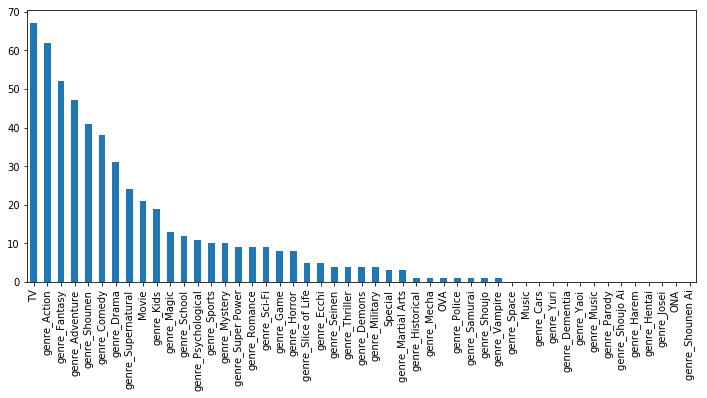

In [26]:
# user history of anime genre - we recommend the genres that the user has watched a lot of and highly rated them.
bar=0
for elem in utility_matrix.loc[row,utility_matrix.loc[row]!=0].index[:-1]:
    bar+=anime_profile.loc[elem]
bar.sort_values(ascending=False).plot(kind='bar',figsize=[12,5])

In [27]:
pd.Series(user_profile[row],anime_profile.columns).sort_values(ascending=False).head(7)

TV                 516.0
genre_Action       452.0
genre_Fantasy      394.0
genre_Adventure    354.0
genre_Shounen      328.0
genre_Comedy       291.0
genre_Drama        231.0
dtype: float64

In [28]:
# recommendations for the user explained
for elem in reco.index:
    print(anime_profile.loc[elem,anime_profile.loc[elem]!=0].index)

Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Drama',
       'genre_Fantasy', 'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Fantasy',
       'genre_Shounen', 'genre_Supernatural', 'TV'],
      dtype='object')
Index(['genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Dr

Depending on the choice of weights that we use for inferring a user profile from the anime profile we can get different answers. Since a single anime has multiple genres, the normalised weighted average over genres gives preference to less seen genre(i.e shounen anime usually have comedy tag too. Suppose 5/10 shounen anime(all rated 8) have comedy tag, then the normalised weight for shounen genre is 8\*10/10 and for comedy also it's 8\*5/5. Now, if there's another anime with tag action,comedy with rating 9. Then comedy weight is 8.12 while shounen weight is 8.) This is intuitively wrong so we don't use normalised weight. This then leads to the preference of genres that are watched a lot and which are highly rated. This gives acceptable recommendations.